# Age Regression with torch distributions

In this notebook you will learn how work with a Distribution in torch. You will set up regression models that are able to output a gaussian conditional probability distribution. You will define different models with Keras and optimize the negative log likelihood (NLL). You will model the conditional probability distribution as a Normal distribution with a constant and flexible standart deviation $\sigma$. The mean $\mu$ of the CPD will depend non-linearly on the input. You will compare the NLL of the two models with the constant and felxible standart deviation $\sigma$. As input data you will use images of faces and you will try to predict the conditional probability distribution of their age.

**Dataset:**
You work with a the UTKFace dataset. It is a large dataset with a large age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The data is already preprocessed and rescaled (80x80 pixels) so you can work with it. You will only use the information of the age and image.

**Content:**
* Load and and split the dataset
* Fit a model with keras and torch distribution that models the CPD with a non-linear mean $\mu$ and a constant standart deviation $\sigma$ .
* Fit a model with keras and torch distribution that models the CPD with a non-linear mean $\mu$ and a flexible standart deviation $\sigma$ with TFP.
* Compare the two models based on the NLL loss on the test dataset.


#### Imports

In [1]:
import numpy as np
import pandas as pd

import urllib
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KERAS_BACKEND"] = "torch"

from keras.models import Sequential, Model
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, Input, Concatenate
from keras.utils import to_categorical
from keras import optimizers
import keras

from torch.distributions import Normal
import torch

#### Loading the data, if it is not loaded

In [2]:
if not os.path.isfile('X_faces.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/5m7nmebpjysqtus/X_faces.npy?dl=1",
    "X_faces.npy")

if not os.path.isfile('Y_age.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/flpyvgdqoatdw0g/Y_age.npy?dl=1",
    "Y_age.npy")


In [3]:
X=np.load("X_faces.npy")
Y=np.load("Y_age.npy")

#### Splitting the data into train, val and test dataset

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=201)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=34)

In [5]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10642, 80, 80, 3)
(5242, 80, 80, 3)
(7824, 80, 80, 3)


#### Looking at the image data

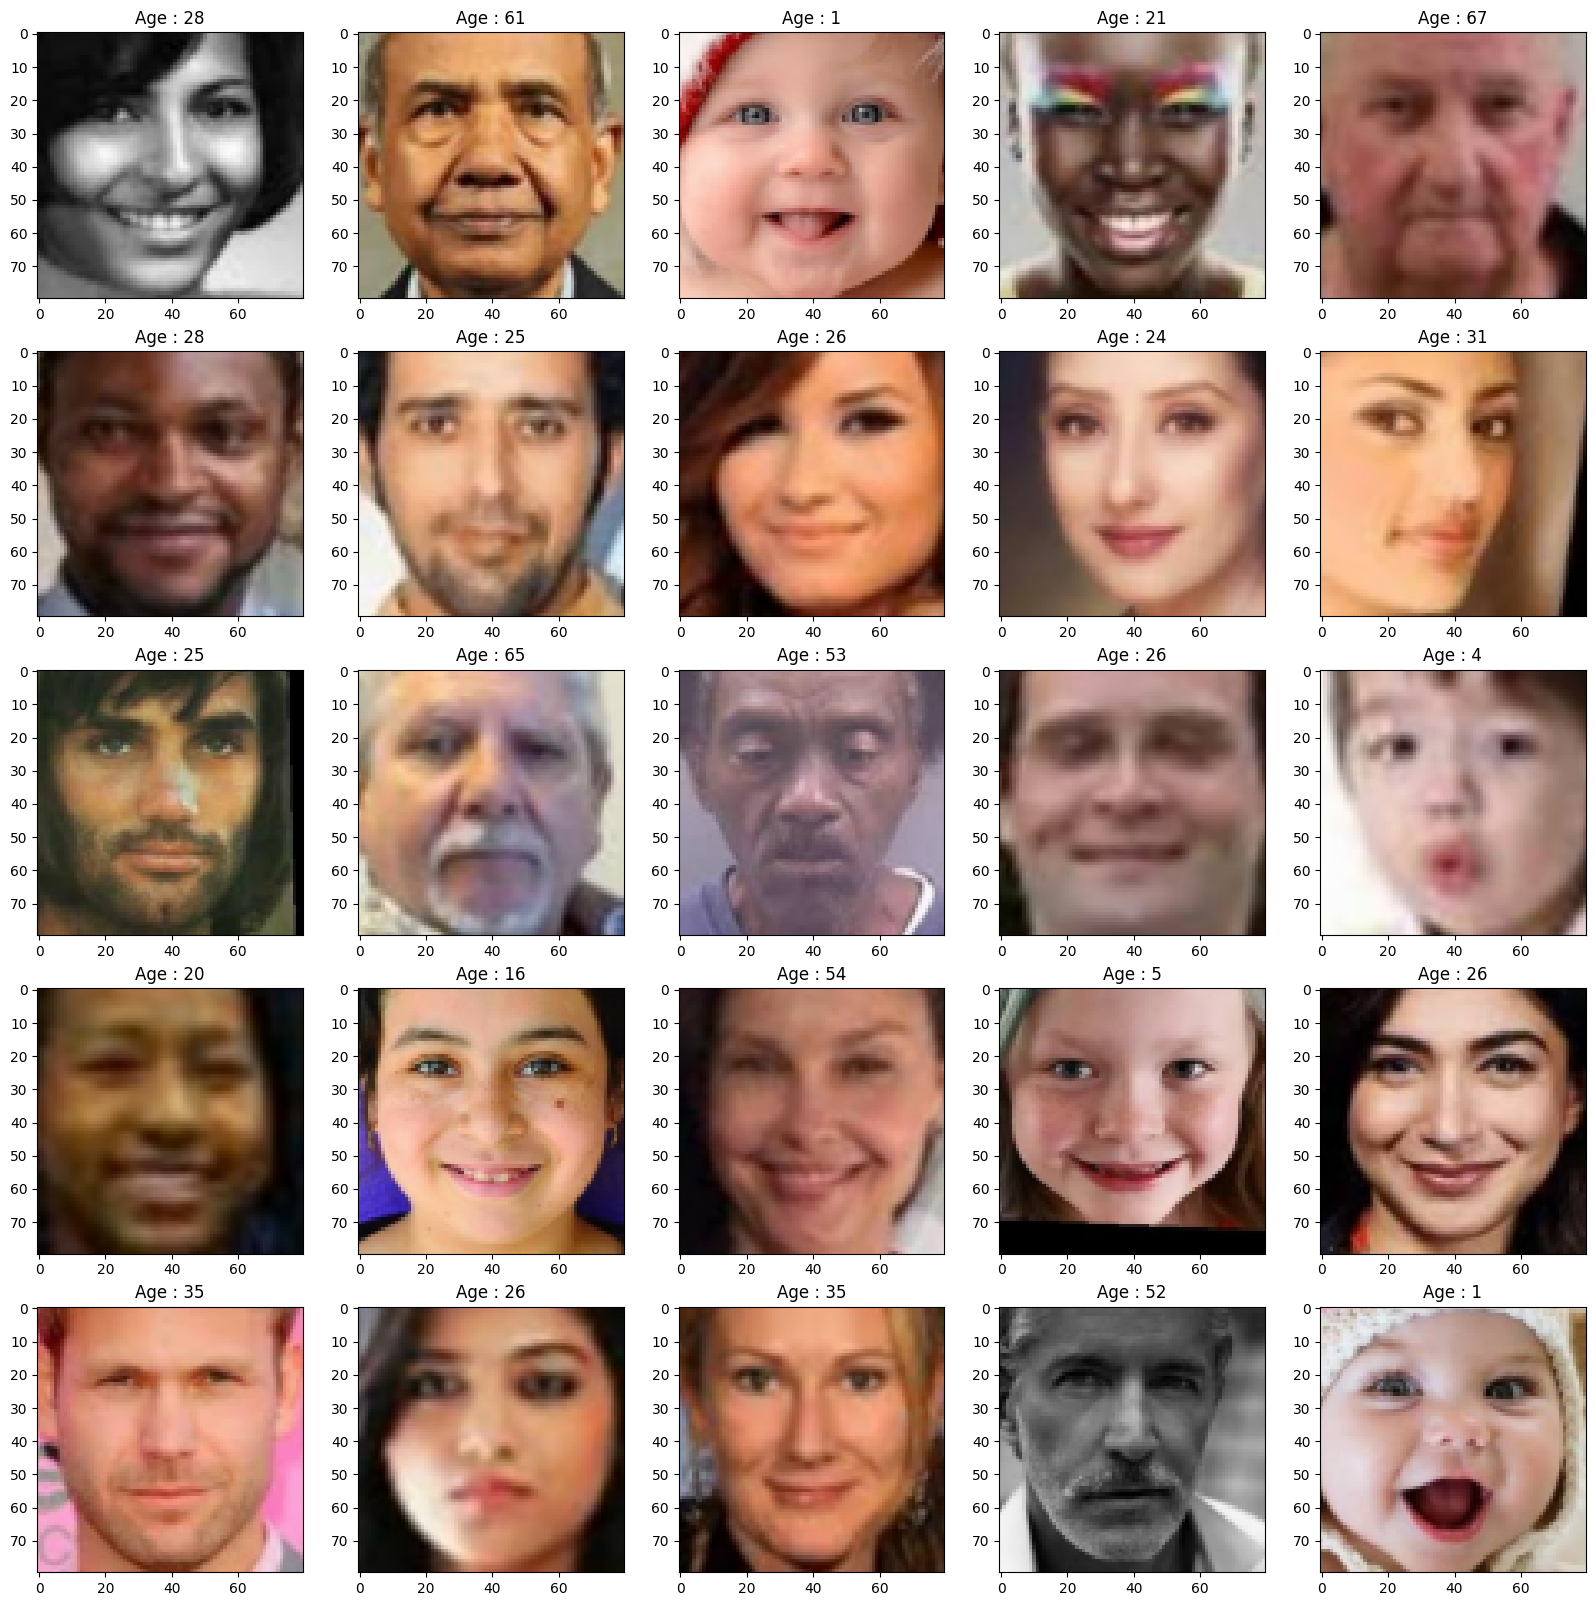

In [6]:
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i])
    plt.title("Age : "+ str(y_train[i]))

#### Normalize the data

In [7]:
X_train=X_train/255
X_val=X_val/255
X_test=X_test/255

In [8]:
X_train = np.array(X_train,dtype="float32")
X_val = np.array(X_val,dtype="float32")
X_test = np.array(X_test,dtype="float32")

y_train = np.array(y_train,dtype="float32")
y_val = np.array(y_val,dtype="float32")
y_test = np.array(y_test,dtype="float32")

#### Looking at the distribution of the target variable

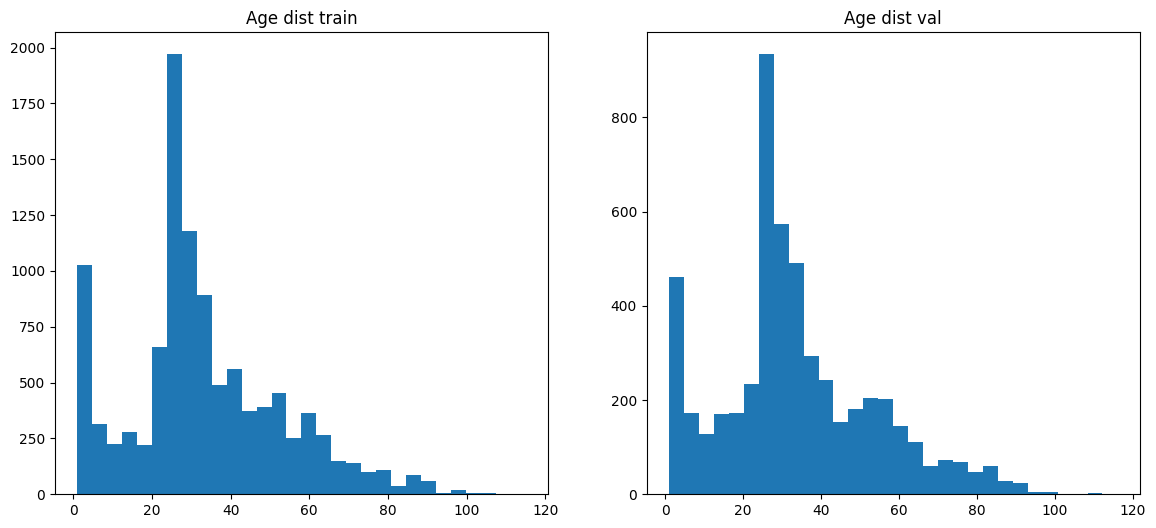

In [9]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.hist(y_train,bins=30)
plt.title("Age dist train")
plt.subplot(1,2,2)
plt.hist(y_val,bins=30)
plt.title("Age dist val")
plt.show()


## Fit a regression model with constant variance
In the next cells you will define and fit a model on the face images. You will use a CNN to model the mu parameter of  a gaussian conditional probability distribution, the sigma will be constant for all inputs. For the loss we use the NLL. Note that we will use the trick with a second input that will be all ones, to model the constant sigma.

In [10]:
kernel_size = (3, 3)
pool_size = (2, 2)

In [11]:
def NLL(y_true, output):
    mean = output[:, 0]
    log_variance = output[:, 1]
    scale = torch.exp(log_variance)  # Ensure positive variance
    dist = Normal(loc=mean, scale=scale) # use distribution here
    return -dist.log_prob(torch.tensor(y_true, dtype=torch.float32)).mean()


input1 = Input(shape=(80,80,3))
input2 = Input(shape=(1,))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(input1)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Flatten()(x)
x = Dense(500,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(50,activation="relu")(x)
x = Dropout(0.3)(x)
out1 = Dense(1)(x)       #mu
out2 = Dense(1)(input2)  #sigma , ## use a trick with two inputs, input2 is just ones
params = Concatenate()([out1,out2])
model_const_sd = Model(inputs=[input1,input2], outputs=params)
model_const_sd.compile(keras.optimizers.Adam(), loss=NLL)


# train the model

history=model_const_sd.fit([X_train, np.expand_dims(np.ones(len(X_train)),1)], y_train,
                    batch_size=16,
                    epochs=40,
                    verbose=1,
                    validation_data=([X_val,np.expand_dims(np.ones(len(X_val)),1)], y_val)
                  )


Epoch 1/40


/tmp/ipykernel_4472/985728253.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -dist.log_prob(torch.tensor(y_true, dtype=torch.float32)).mean()


666/666 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 5624.0869 - val_loss: 1341.3428
Epoch 2/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 1015.7420 - val_loss: 376.6793
Epoch 3/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 394.5189 - val_loss: 197.9223
Epoch 4/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 194.2693 - val_loss: 128.7930
Epoch 5/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 131.1267 - val_loss: 81.0453
Epoch 6/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 83.5762 - val_loss: 55.4675
Epoch 7/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 59.6849 - val_loss: 37.9788
Epoch 8/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 42.2255 - val_loss: 30.0932
Epoch 9/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 30.7875 - val_loss: 25.7490
Epoch 10/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 22.1743 - val_loss: 16.5385
Epoch 11/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 16.5701 - val_loss: 12.8703
Epoch 12/4

KeyboardInterrupt: 

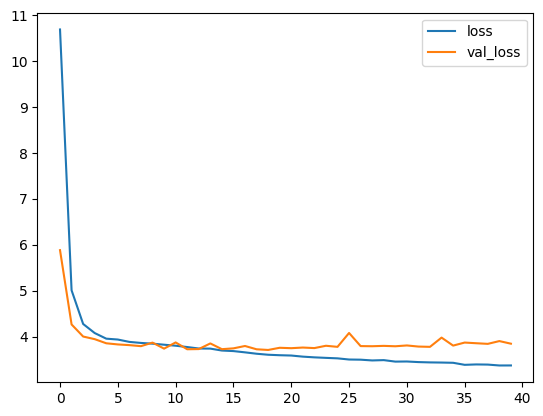

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#### Look at the predicted mean of the CPD on the testset


In [14]:
plt.figure(figsize=(18,18))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    pred=model_const_sd([X_test[i:i+1], np.expand_dims(np.ones(len(X_test[i:i+1])),1)]).data.detach().cpu().numpy()[0][0]
    plt.title("pred : "+ str(round(float(pred), 2)) + "   true : "+ str(y_test[i]))

Output hidden; open in https://colab.research.google.com to view.

#### Look at the predicted mean and the predicted sigma of the CPD on the testset


In [15]:
# distribution used for the model -> model outputs loaction and a value for the scalinpout
def my_dist(output):
    mean = output[:, 0]
    log_variance = output[:, 1]
    scale = torch.exp(log_variance)  # Ensure positive scale
    return Normal(loc=mean, scale=scale)

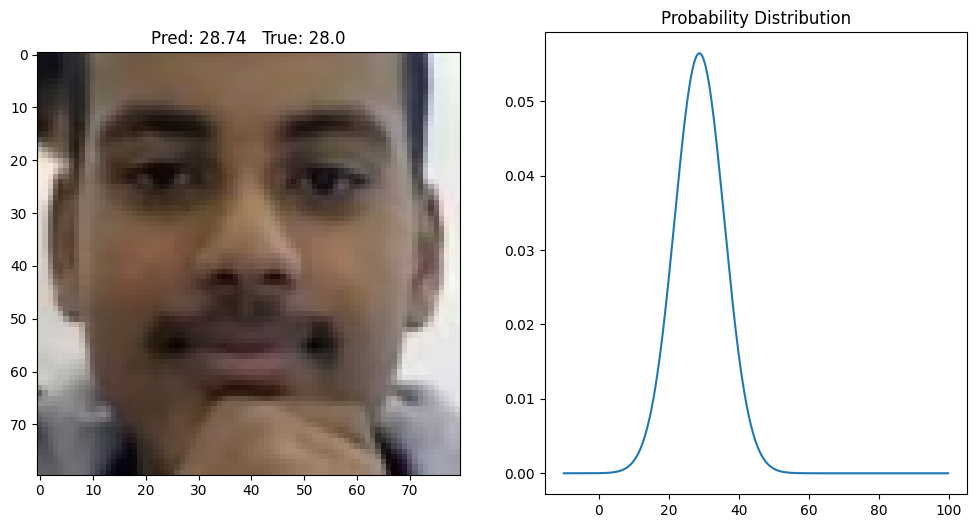

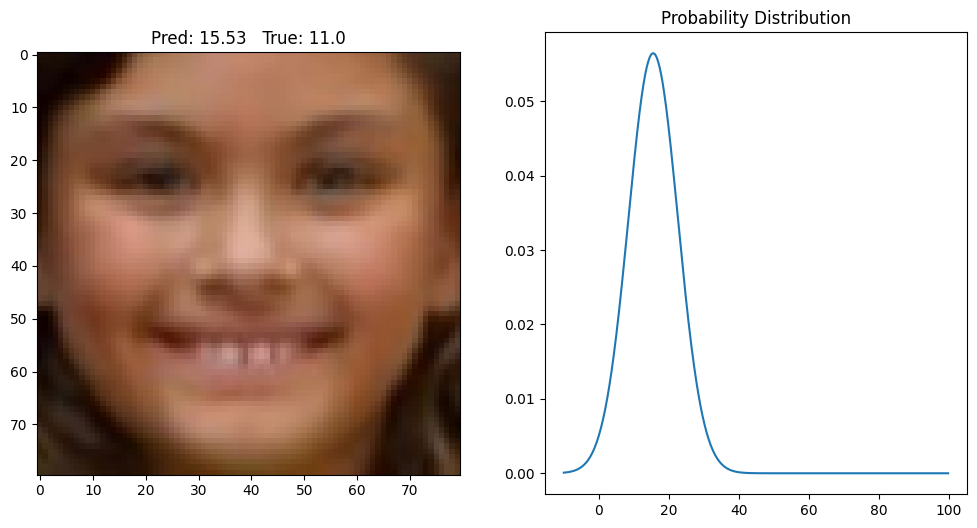

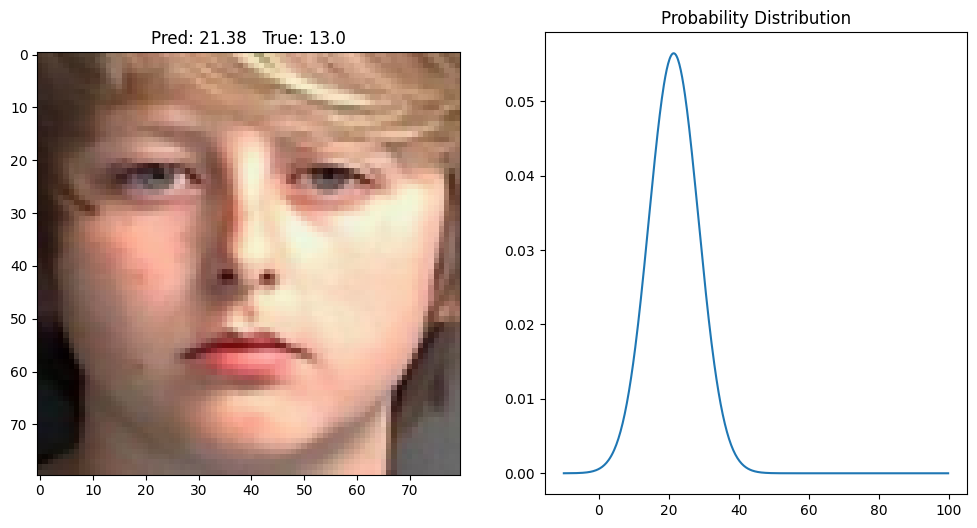

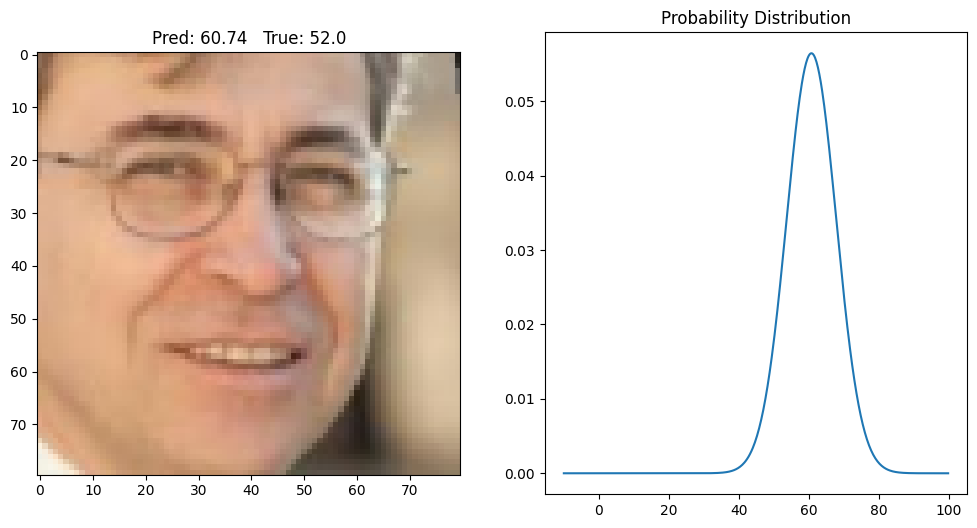

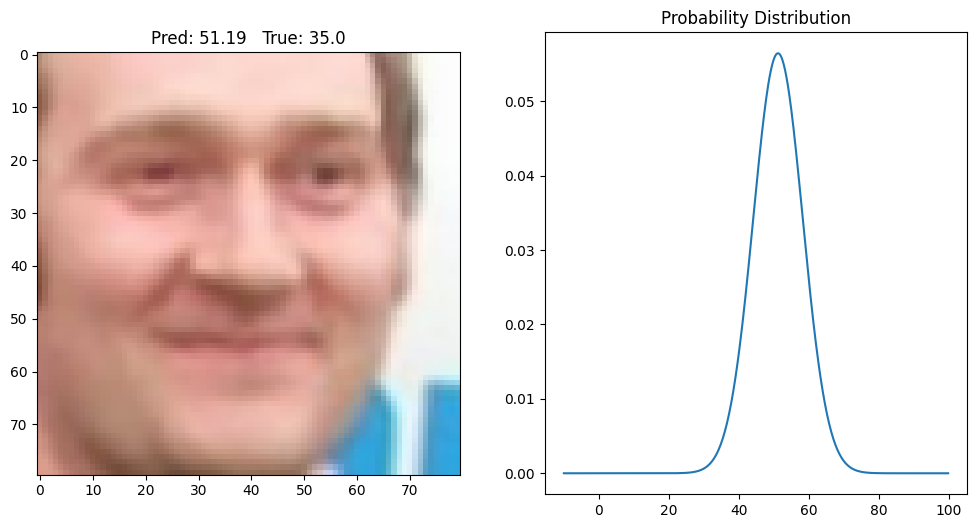

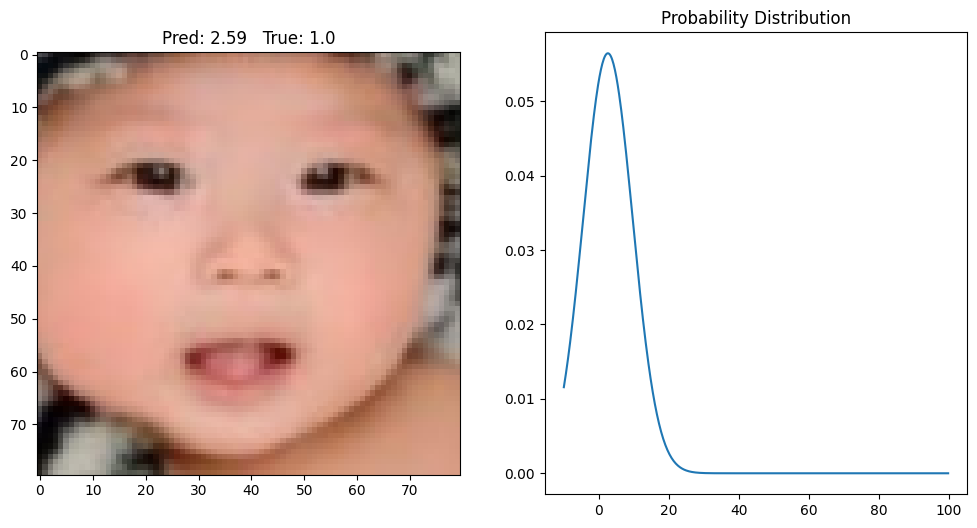

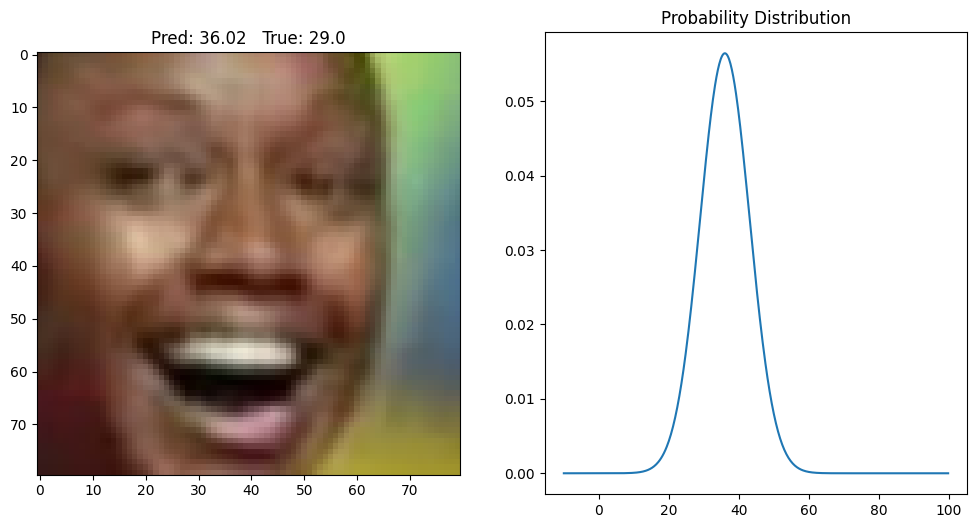

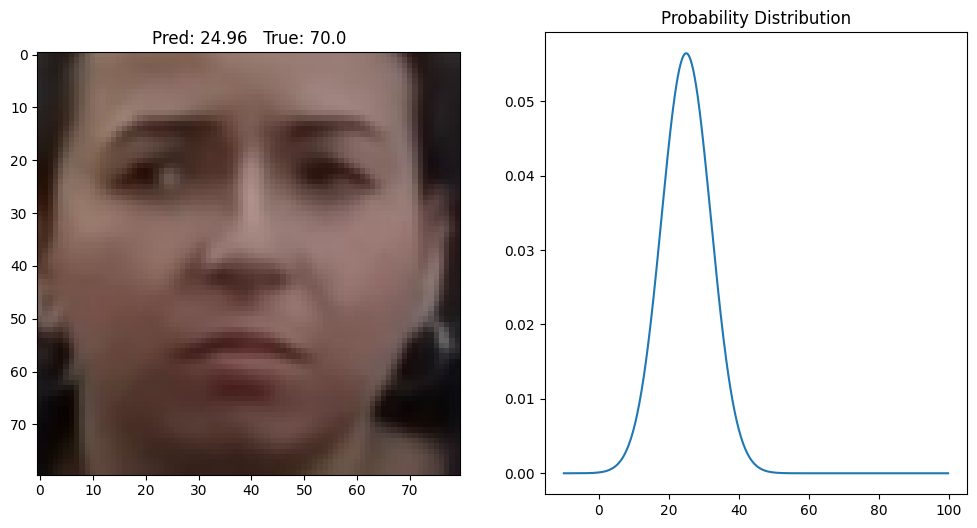

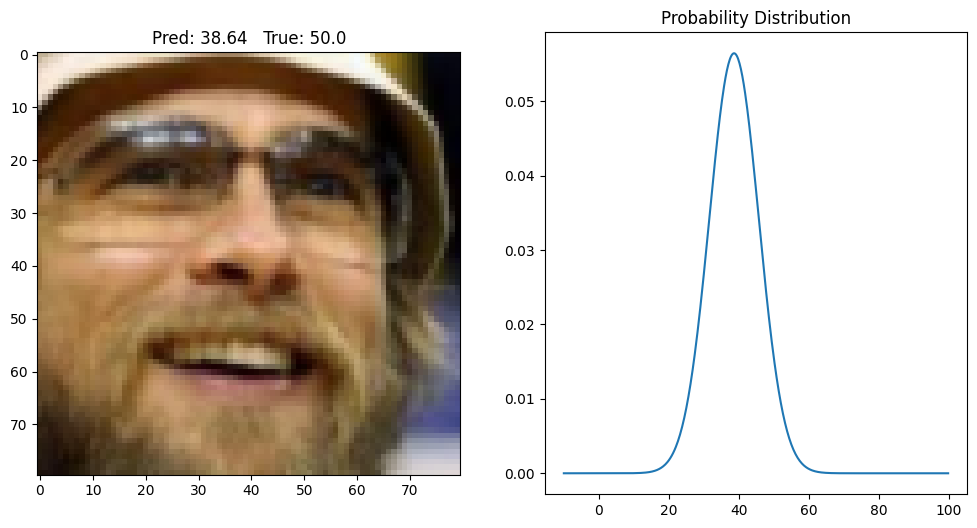

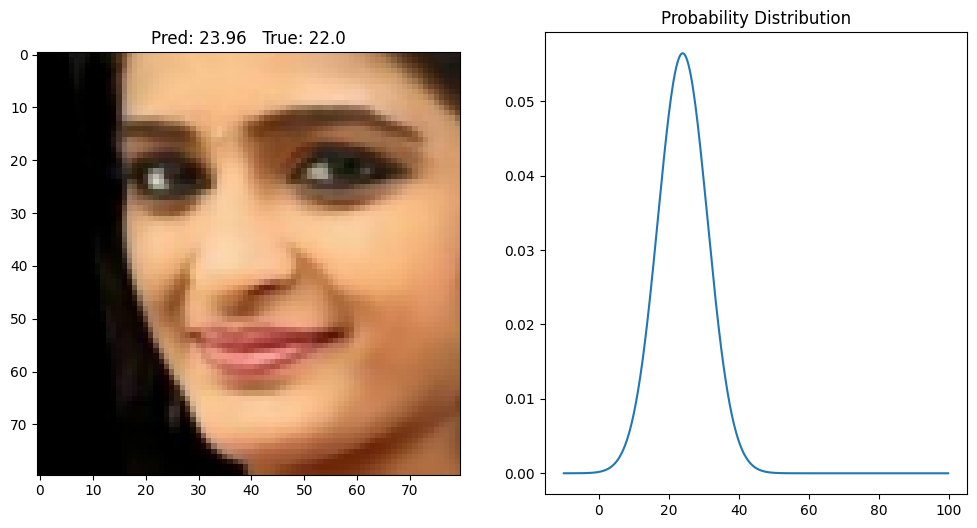

In [16]:
for i in range(0, 10):
    plt.figure(figsize=(12, 6))

    # image
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i])

    # predictions
    pred = model_const_sd([X_test[i:i+1], np.expand_dims(np.ones(len(X_test[i:i+1])), 1)])
    pred = pred.data.detach().cpu().numpy()

    # distribution
    dist = my_dist(torch.Tensor(pred))


    plt.title("Pred: " + str(round(float(dist.mean), 2)) +
              "   True: " + str(y_test[i]))
    # plot cdf
    plt.subplot(1, 2, 2)
    x_range = np.arange(-10, 100, 0.2)
    log_probs = dist.log_prob(torch.tensor(x_range, dtype=torch.float32))  # Remove [0]
    plt.plot(x_range, torch.exp(log_probs).detach().cpu().numpy())  # Convert log-probs to PDF
    plt.title("Probability Distribution")
    plt.show()

## Fit a regression model with felxible variance
In the next cells you will afain define and fit a model on the face images. You will use a CNN to model the mu parameter of a gaussian conditional probability distribution, but this time the sigma will not be constant for all inputs. Every iamge will be able to have a different sigma. For the loss we use the NLL.

In [17]:
def NLL(y_true, output):
    mean = output[:, 0]
    log_variance = output[:, 1]
    scale = torch.exp(log_variance)  # Ensure positive variance
    dist = Normal(loc=mean, scale=scale) # use distribution here
    return -dist.log_prob(torch.tensor(y_true, dtype=torch.float32)).mean()

inputs = Input(shape=(80,80,3))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(inputs)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Flatten()(x)
x = Dense(500,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(50,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(2)(x)


model_flex = Model(inputs=inputs, outputs=x)
model_flex.compile(keras.optimizers.Adam(), loss=NLL)


In [18]:
# train the model
history=model_flex.fit(X_train, np.array(y_train,dtype="float32"),
                  batch_size=16,
                  epochs=40,
                  verbose=1,
                  validation_data=(X_val, np.array(y_val,dtype="float32")))


Epoch 1/40
 12/666 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 398.6488

/tmp/ipykernel_2044860/974142931.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -dist.log_prob(torch.tensor(y_true, dtype=torch.float32)).mean()


666/666 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 26.8432 - val_loss: 5.1133
Epoch 2/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 5.2112 - val_loss: 4.6812
Epoch 3/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 4.9694 - val_loss: 4.4982
Epoch 4/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4.9623 - val_loss: 4.3657
Epoch 5/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4.9394 - val_loss: 4.7818
Epoch 6/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4.8313 - val_loss: 4.5120
Epoch 7/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4.7791 - val_loss: 4.2818
Epoch 8/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4.6380 - val_loss: 4.2636
Epoch 9/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4.6875 - val_loss: 4.4931
Epoch 10/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4.5955 - val_loss: 4.7651
Epoch 11/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4.5550 - val_loss: 4.0738
Epoch 12/40
666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - los

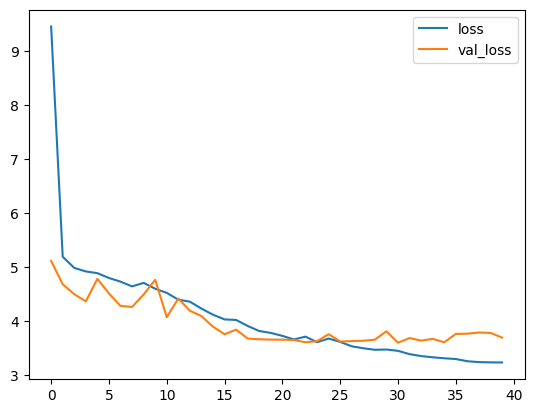

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#### Look at the predicted mean of the CPD on the testset


In [20]:
plt.figure(figsize=(18,18))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    pred=model_flex(X_test[i:i+1]).data.detach().cpu().numpy()[0][0]
    plt.title("pred : "+ str(round(float(pred), 2)) + "   true : "+ str(y_test[i]))

Output hidden; open in https://colab.research.google.com to view.

#### Look at the predicted mean and the predicted sigma of the CPD on the testset


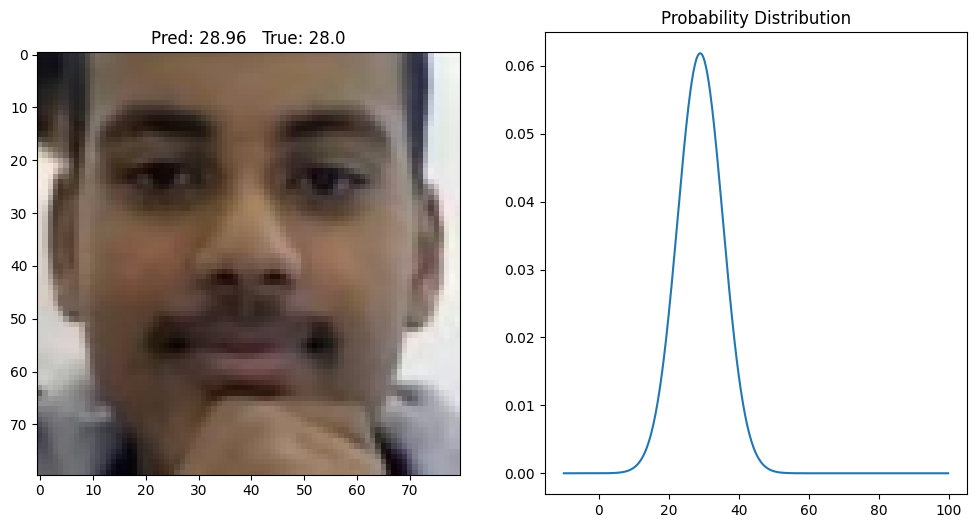

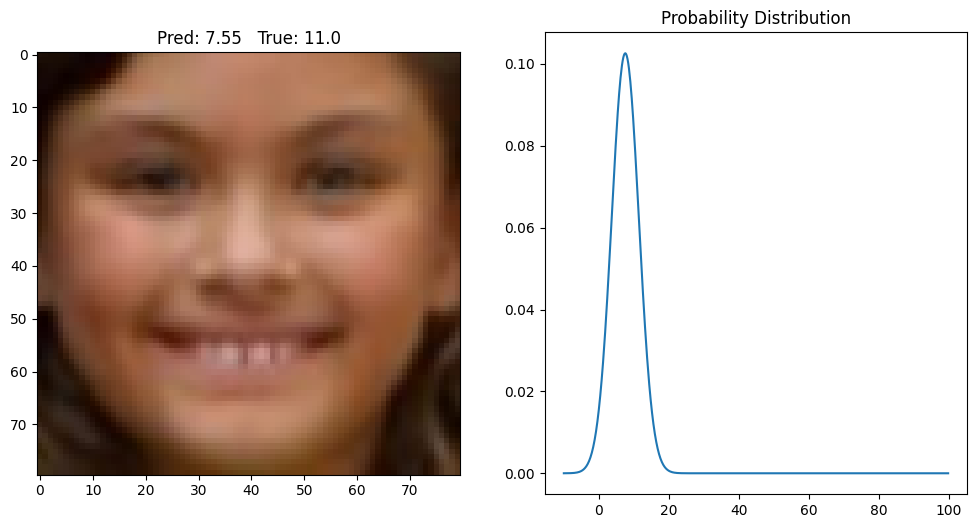

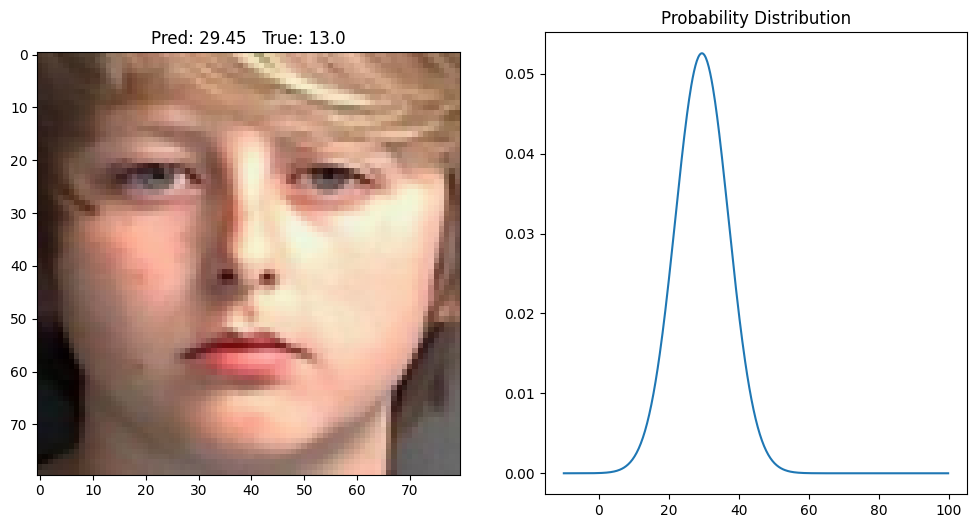

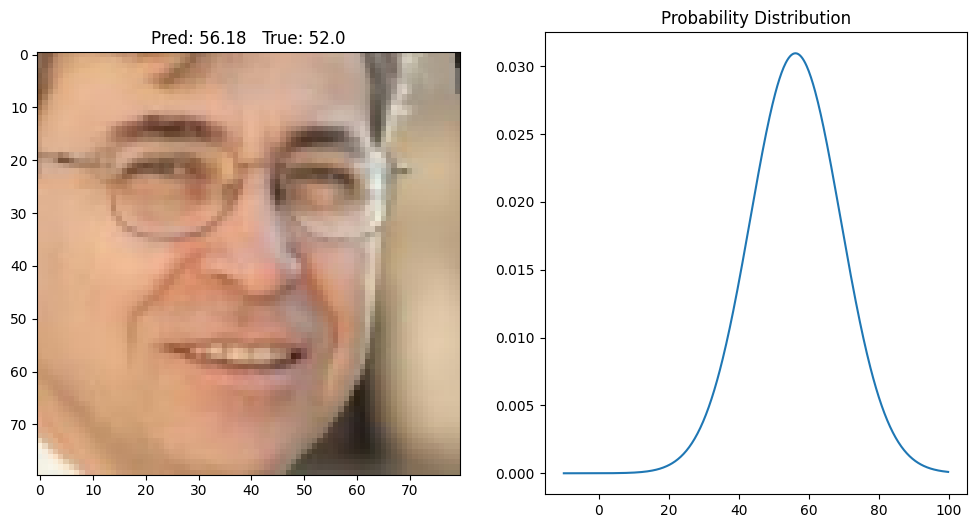

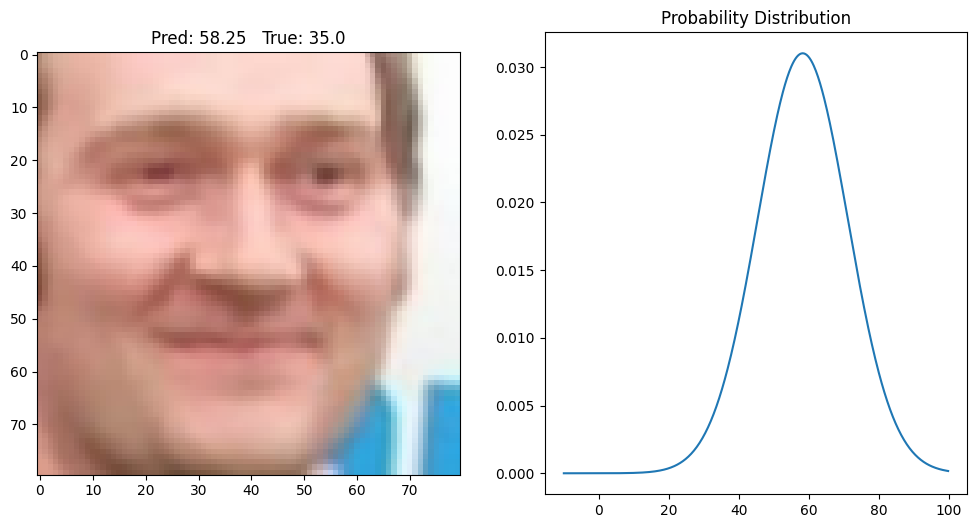

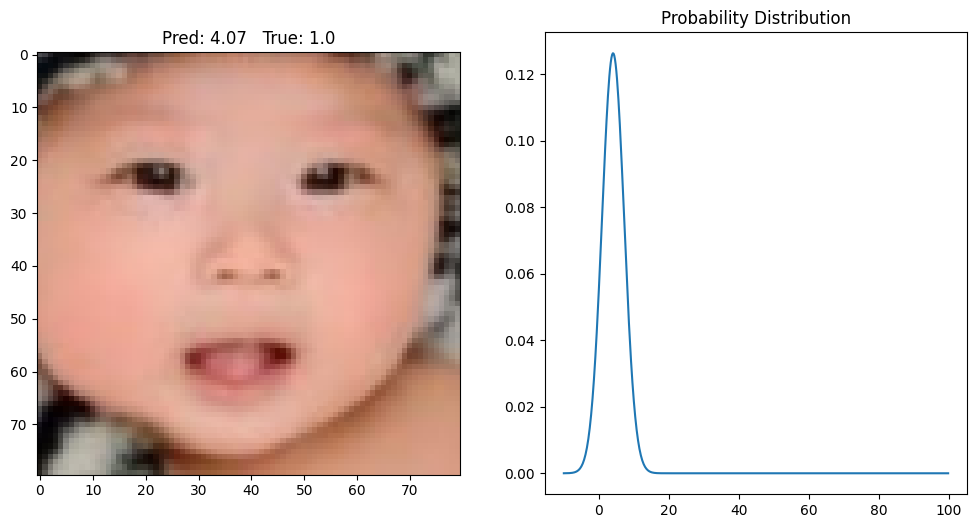

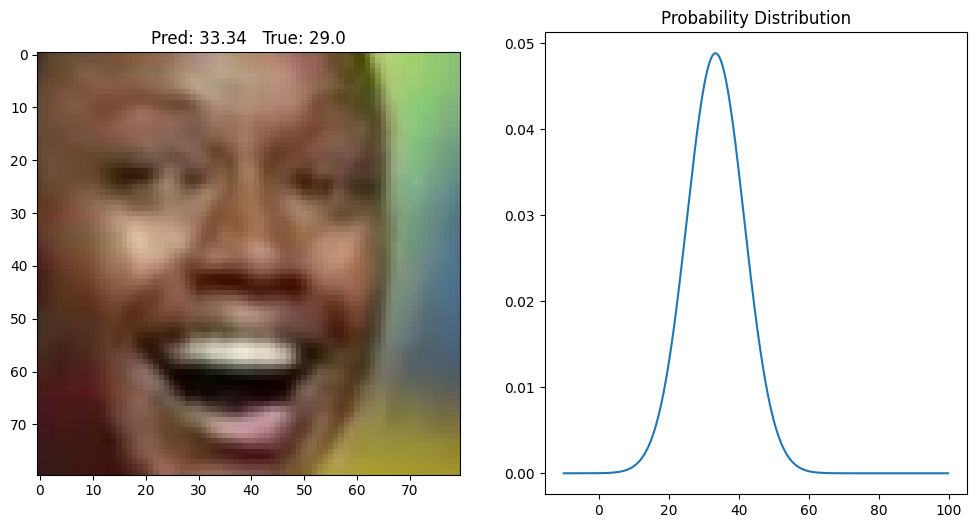

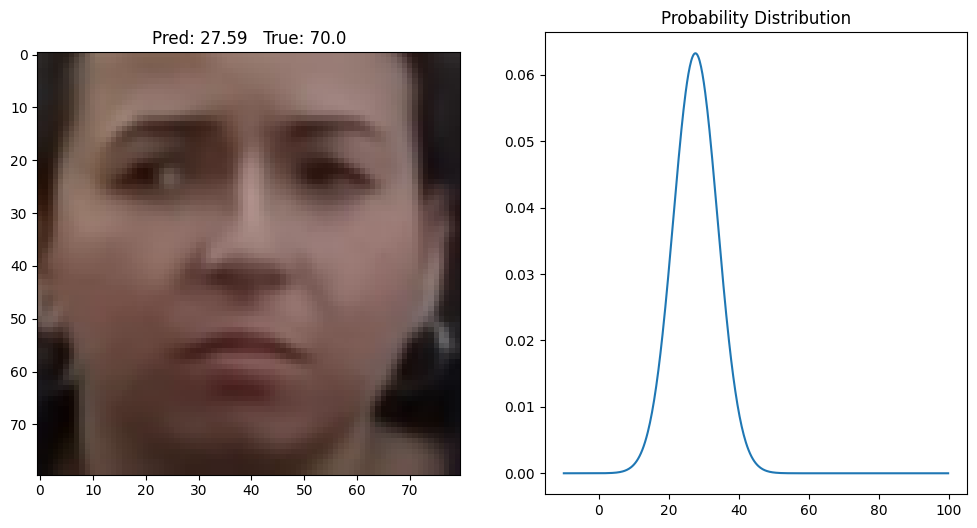

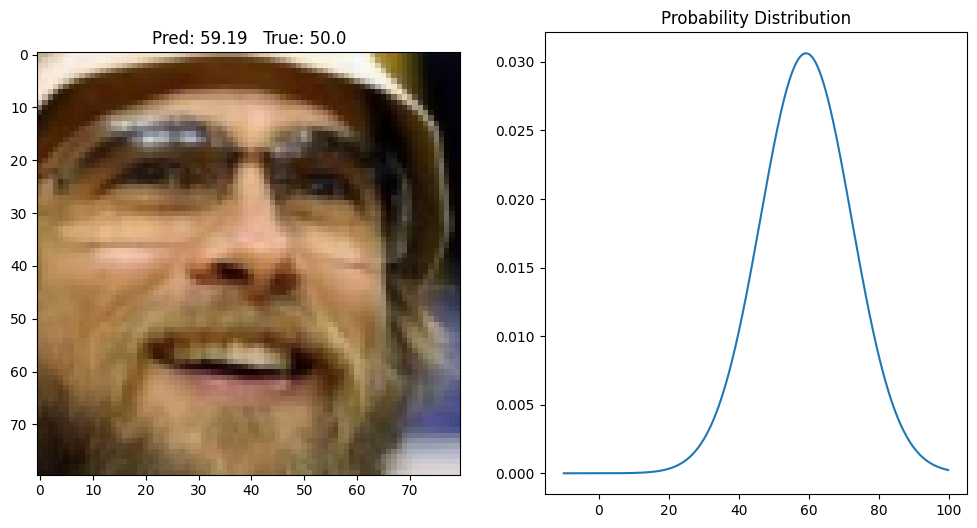

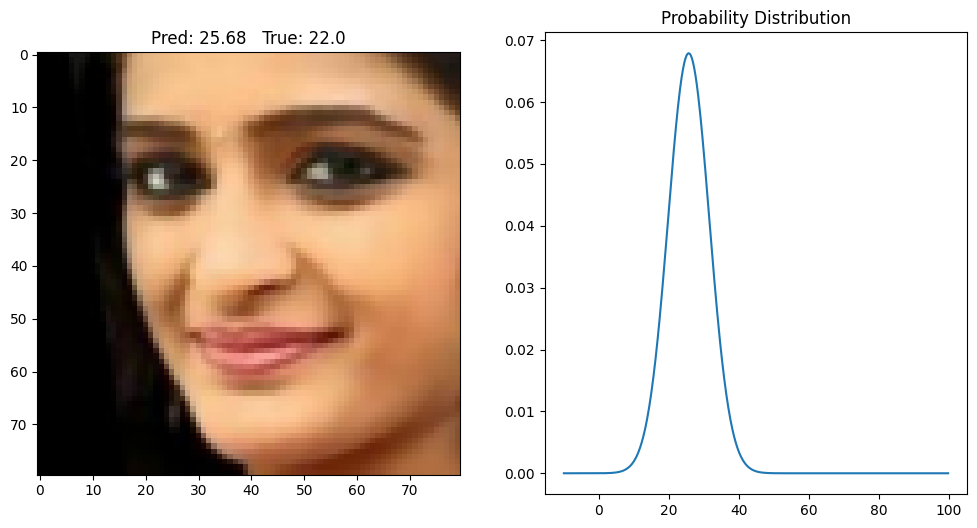

In [21]:
for i in range(0, 10):
    plt.figure(figsize=(12, 6))

    # image
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i])

    # predictions
    pred = model_flex(X_test[i:i+1])
    pred = pred.data.detach().cpu().numpy()

    # distribution
    dist = my_dist(torch.Tensor(pred))


    plt.title("Pred: " + str(round(float(dist.mean), 2)) +
              "   True: " + str(y_test[i]))
    # plot cdf
    plt.subplot(1, 2, 2)
    x_range = np.arange(-10, 100, 0.2)
    log_probs = dist.log_prob(torch.tensor(x_range, dtype=torch.float32))  # Remove [0]
    plt.plot(x_range, torch.exp(log_probs).detach().cpu().numpy())  # Convert log-probs to PDF
    plt.title("Probability Distribution")
    plt.show()

### 🔧 **YOUR TASK:**
Calculate the MSE the RMSE and the NLL for both models on the testset.  
Which model would you prefer in practice and why?  



In [22]:
### Your code here

<details>
  <summary>💡 Hint:</summary>


heres how you geet all the predicitons without OOM

```
i = 0
mu1 = []
mu2 = []
for i in range(len(X_test)):
    mu1.append( model_const_sd([X_test[i:i+1], np.expand_dims(np.ones(len(X_test[i:i+1])), 1)]).data.detach().cpu().numpy()[0])
    mu2.append( model_flex([X_test[i:i+1]]).data.detach().cpu().numpy()[0])

mu1=np.array(mu1)
mu2=np.array(mu2)
```


</details>

### `🔑` **Solution:**

<details>
  <summary>🔑 Click here to View Answers:</summary>

The model with the nonflexible CPD has the lower MSE and RMSE but NLL is still larger.

The flexible model outputs a distribution for every input and therefore is more useful in practice.
</details>

In [23]:
# @title 🔑 Solution Code { display-mode: "form" }
# prediction in for loop because else OOM error (Out Of Memory)
i = 0
mu1 = []
mu2 = []
for i in range(len(X_test)):
    mu1.append( model_const_sd([X_test[i:i+1], np.expand_dims(np.ones(len(X_test[i:i+1])), 1)]).data.detach().cpu().numpy()[0])
    mu2.append( model_flex([X_test[i:i+1]]).data.detach().cpu().numpy()[0])

mu1=np.array(mu1)
mu2=np.array(mu2)

# metrics
mse_1 = np.average(np.square(mu1[:,0]-y_test))
rmse_1 = np.sqrt(mse_1)
nll_1 = model_const_sd.evaluate([X_test,np.expand_dims(np.ones(len(X_test)),1)],y_test,verbose=0)

mse_2 = np.average(np.square(mu2[:,0]-y_test))
rmse_2 = np.sqrt(mse_2)
nll_2 = model_flex.evaluate(X_test,y_test,verbose=0)

df1 = pd.DataFrame(
         { 'MSE' : mse_1, 'RMSE' : rmse_1, 'nll ' : nll_1}, index=['model const sigma'])
df2 = pd.DataFrame(
         { 'MSE' : mse_2, 'RMSE' : rmse_2, 'nll ' : nll_2}, index=['model flex sigma'])
pd.concat([df1,df2])

/tmp/ipykernel_2044860/1306819553.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -dist.log_prob(torch.tensor(y_true, dtype=torch.float32)).mean()


,MSE,RMSE,nll
model const sigma,98.642159,9.931876,3.861262
model flex sigma,119.518150,10.932436,3.745750
